In [2]:
import os

ref_img = os.environ['WIN_SVR_DATA']+'B4.tif'
sec_img = os.environ['WIN_SVR_DATA']+'Saldana/otb_superimposed.tif'

In [3]:
from skimage import io

image = io.imread(ref_img)
offset_image = io.imread(sec_img)

In [4]:
from dask.distributed import Client
client = Client(n_workers=24)
client

Client Scheduler: tcp://127.0.0.1:42228 Dashboard: http://127.0.0.1:57730/status,Cluster Workers: 24 Cores: 24 Memory: 33.55 GB


In [5]:
# Get the data 
# Load data
import sys
sys.path.append('../b_Temporal_Stack')
import regionstack
import eotempstack
import xr_eotemp

saldana = regionstack.regionStack('Saldana_training_2015')
# Select dates

s2 = saldana.S2.sel(time='2015-12-21')

l8 = saldana.LC08.sel(time='2015-12-22')

S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Stacking S1 failed: <class 'StopIteration'>  <traceback object at 0x7f8f840cb848>
Reading 8 S1 stack files
S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Stacking S1 failed: <class 'StopIteration'>  <traceback object at 0x7f8f6c14fa08>
Reading 6 S1 stack files
GLCM_S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 4 GLCM_S1 stack files
GLCM_S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 3 GLCM_S1 stack files
S2 object initialized from /mnt/workspace_cluster_6/TRANSVER

In [ ]:
from matplotlib import pyplot as plt
from skimage.transform import SimilarityTransform
from skimage.transform import warp
    
def apply_bp_correction_lc08(lc08dataset, offset = [3.37, 1.18]):
    """
    
    Args:
        lc08dataset (xarray.Dataset): Landsat-8 dataset to correct
        offset ([float,float]): image offset (y,x) between S2 and LC08 images
    
    """
    
    lr_harm = {'blue':[1.0/0.977, -0.00411/-0.977],'green':[1.0/1.005, -0.00093/-1.005],
               'red':[1.0/0.982, 0.00094/-0.982],'nir':[1.0/1.001, -0.00029/-1.001],
               'swir1':[1.0/1.001,-0.00015/-1.001],'swir2':[1.0/0.996,-0.00097/-0.996]}
    
    # Apply bandpass adjustment
    for band, coeff in lr_harm.items():
        try:
            print('Correcting {} band'.format(band))
            lc08dataset[band] = coeff[0]*lc08dataset[band].compute()+coeff[1]
        except KeyError: #when band is not in dataset
            pass

def apply_geo_correction_lc08(lc08dataset, offset = [3.37, 1.18]):
    # Correct pixel offset
    tform = SimilarityTransform(translation=(-offset[1],-offset[0]))
    
    #print(list(lc08dataset.variables.keys()))
    vars_in_ds = [band for band in list(lc08dataset.variables.keys()) if band not in ['time','y','x']]
    #print(vars_in_ds)
    
    for band in vars_in_ds:
        try:
            print('Warping {} band to y={},x={} offset'.format(band, offset[1], offset[0]))
            lc08dataset[band] = xr.apply_ufunc(correct_offset_ufunc,
                                               lc08dataset[band].compute(),
                                               input_core_dims=[['time']],
                                               output_core_dims=[['time']],
                                               kwargs={#'axis': -1,
                                                       'transform': tform})
        except:
            e = sys.exc_info()
            print('Warp for band {} failed with error {}, {}, {}'.format(band, e[0], e[1], e[2]))
    
    return lc08dataset

In [6]:
s2.red.drop('time').drop('mask')

<xarray.DataArray 'red' (y: 3631, x: 2979)>
dask.array<shape=(3631, 2979), dtype=uint16, chunksize=(1000, 1000)>
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...

In [7]:
import xarray as xr

red = xr.Dataset({'s2': s2.red.drop('time').drop('mask'), 'l8': l8.red.drop('time').drop('mask')})

In [8]:
red = red.compute()

In [1]:
client.close()

NameError: name 'client' is not defined

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

In [12]:
image = np.nan_to_num(red.s2.data)
image.shape

(3635, 2981)

In [13]:
offset_image = np.nan_to_num(red.l8.data)
offset_image.shape

(3635, 2981)

In [14]:
# pixel precision first
shift, error, diffphase = register_translation(image, offset_image)

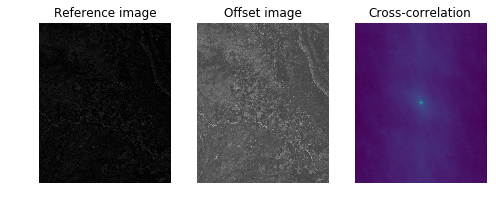

Detected pixel offset (y, x): [3. 1.]


In [15]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print("Detected pixel offset (y, x): {}".format(shift))

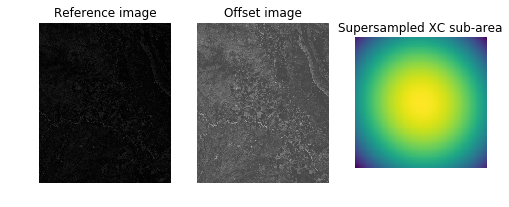

Detected subpixel offset (y, x): [3.37 1.18]


In [16]:
# subpixel precision
shift, error, diffphase = register_translation(image, offset_image, 100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")

plt.show()

print("Detected subpixel offset (y, x): {}".format(shift))

In [63]:
error

0.23027402301947741

In [59]:
from skimage.transform import SimilarityTransform
from skimage.transform import warp

tform = SimilarityTransform(translation=(-shift[1],-shift[0]))
warped = warp(offset_image, tform)

In [60]:
shift2, error2, diffphase2 = register_translation(image, warped, 100)

In [64]:
shift2

array([-0.01,  0.  ])

In [65]:
warped.shape

(3635, 2981)

In [57]:
offset_image.shape

(3635, 2981)

In [29]:
tform.translation

array([3.37, 1.18])

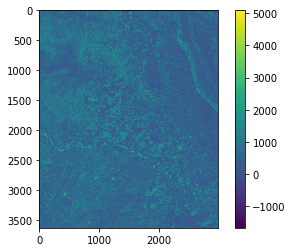

In [66]:
plt.imshow(offset_image)
plt.colorbar()

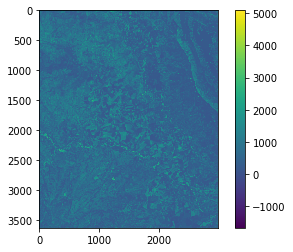

In [67]:
plt.imshow(warped)
plt.colorbar()

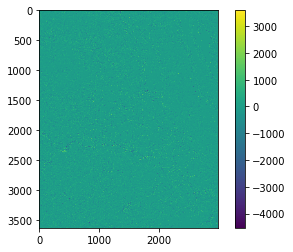

In [68]:
plt.imshow(warped-offset_image)
plt.colorbar()

In [38]:
import rasterio
import xarray as xr
import numpy as np
import pandas as pd
import os

def xarray_to_rasterio(xa, output_filename):
    """Converts the given xarray.DataArray object to a raster output file
    using rasterio.
    Arguments:
     - `xa`: The xarray.DataArray to convert
     - `output_filename`: the filename to store the output GeoTIFF file in
    Notes:
    Converts the given xarray.DataArray to a GeoTIFF output file using rasterio.
    This function only supports 2D or 3D DataArrays, and GeoTIFF output.
    The input DataArray must have attributes (stored as xa.attrs) specifying
    geographic metadata, or the output will have _no_ geographic information.
    If the DataArray uses dask as the storage backend then this function will
    force a load of the raw data.
    https://github.com/robintw/XArrayAndRasterio
    
    ---
    Modified coordinates of np.array using the affine attribute, flipping coordinates
    when coordinates are decreasing. Requires transposed array (y, x). TODO implement transpose
    
    """
    # Forcibly compute the data, to ensure that all of the metadata is
    # the same as the actual data (ie. dtypes are the same etc)
    xa = xa.load()

    if len(xa.shape) == 2:
        count = 1
        height = xa.shape[0]
        width = xa.shape[1]
        band_indicies = 1
    else:
        count = xa.shape[0]
        height = xa.shape[1]
        width = xa.shape[2]
        band_indicies = np.arange(count) + 1

    processed_attrs = {}

    # Get values to write
    bands_to_write = xa.values
    
    try:
        val = xa.attrs['affine']
        processed_attrs['affine'] = rasterio.Affine.from_gdal(*val)
        # Test if axes need to be inversed
        if val[1] < 0:
            bands_to_write = np.flip(bands_to_write, axis=2)
        if val[5] < 0:
            bands_to_write = np.flip(bands_to_write, axis=1)
    except KeyError:
        raise KeyError('affine attribute is not present in dataset')
    try:
        val = xa.attrs['crs']
        processed_attrs['crs'] = rasterio.crs.CRS.from_string(val)
    except KeyError:
        raise KeyError('crs attribute is not present in dataset')
    
    with rasterio.open(output_filename, 'w',
                       driver='GTiff',
                       height=height, width=width,
                       dtype=str(xa.dtype), count=count,
                       **processed_attrs) as dst:
        dst.write(bands_to_write, band_indicies)
        

In [50]:
crs = '+init=epsg:32618'
transform = (488900.0, 10.0, -0.0, 448460.0, -0.0, -10.0)

In [69]:
red['l8_c'] = (('y','x'), warped)

In [70]:
optical = xr.merge([red, s2.blue, s2.green])

In [71]:
bands = ['red','green','blue'] #xr.Variable('time', pd.DatetimeIndex(np.array([s2.time.values, l8.time.values])))
s2_array = xr.concat([optical.s2, optical.green, optical.blue], dim=bands)
m_array = xr.concat([optical.l8, optical.green, optical.blue], dim=bands)
c_array = xr.concat([optical.l8_c, optical.green, optical.blue], dim=bands)

In [72]:
s2_array.attrs['crs'] = crs
s2_array.attrs['affine'] = transform
m_array.attrs['crs'] = crs
m_array.attrs['affine'] = transform
c_array.attrs['crs'] = crs
c_array.attrs['affine'] = transform

In [73]:
xarray_to_rasterio(s2_array, os.environ['WIN_SVR_DATA']+'s2_orig.tif')
xarray_to_rasterio(m_array, os.environ['WIN_SVR_DATA']+'s2_l8red.tif')
xarray_to_rasterio(c_array, os.environ['WIN_SVR_DATA']+'s2_l8redc.tif')